## Adaptive subtraction (patch)

We now move to a field data example with the Voring dataset where we have the total data and an initial estimate of the multiples on complete shot gathers.

First, we import the required libraries.

In [426]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import segyio
import pylops

from pylops.optimization.sparsity import FISTA
from pylops.optimization.solver import lsqr
from ADMM import ADMM
from IRLS import IRLS

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Voring data

The Voring dataset is a composed of common shot gathers. Let's load the total data, initial estimate of multiples and SRME multiples.

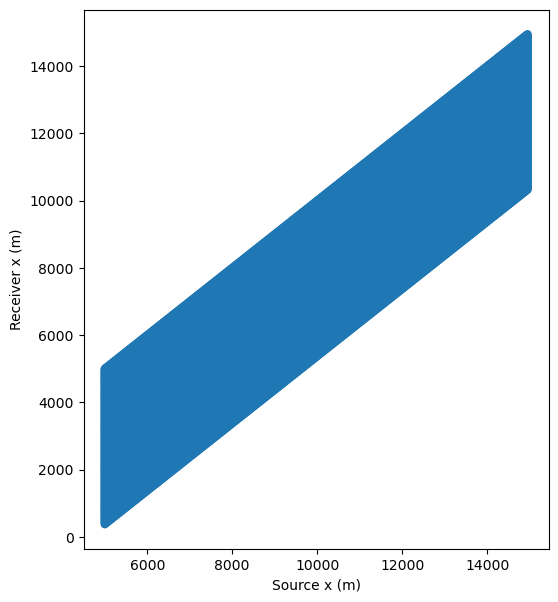

Number of traces is 74214 
First shot is 627 and last shot is 1025
Number of shots is 399 
Number of receivers is 186
Found new shot 800 at trace 32178


In [472]:
# read the Saga Voring shots file

filename_1 = 'Data/Voring/shots.inter.su'        # total data
filename_2 = 'Data/Voring/shots.multwav.su'      # estimate of multiples
filename_3 = 'Data/Voring/shots.srme.su'         # estimate of multiples

with segyio.su.open(filename_1, ignore_geometry=True, endian='little') as sufile_1:
    with segyio.su.open(filename_2, ignore_geometry=True, endian='little') as sufile_2:
        with segyio.su.open(filename_3, ignore_geometry=True, endian='little') as sufile_3:
            # map all the headers
            sufile_1.mmap()
            sufile_2.mmap()
            sufile_3.mmap()

            # Extract some headers for all traces
            fldr = sufile_1.attributes(segyio.su.fldr)[:] # shot number for each trace
            sx = sufile_1.attributes(segyio.su.sx)[:]  # source positions
            gx = sufile_1.attributes(segyio.su.gx)[:]  # receiver positions
            ns_all = sufile_1.attributes(segyio.su.ns)[:]
            ns=ns_all[0]   # number of samples 
            dtus_all = sufile_1.attributes(segyio.su.dt)[:]
            dtus=dtus_all[0]   
            scalco_all = sufile_1.attributes(segyio.su.scalco)[:]
            scalco=scalco_all[0]
            ntr=len(fldr)   # number of traces

            # determine from scalco scale factor for the coordinates
            scl=1.0
            if scalco <0 :
                scl=1 / abs(scalco)
            if scalco > 0:
                scl=abs(scalco)

            # determine dt from dtus
            dt=dtus/1000000

            # Scatter plot of shot numbers versus trace numbers
            plt.figure(figsize=(6,7))
            plt.scatter(sx*scl, gx*scl, edgecolor='none')
            plt.xlabel('Source x (m)')
            plt.ylabel('Receiver x (m)')
            plt.show()

            # display some info
            print('Number of traces is %d ' %(ntr))
            print('First shot is %d and last shot is %d' %(fldr[0],fldr[ntr-1]))
            print('Number of shots is %d ' %(fldr[ntr-1]-fldr[0]+1))
            print('Number of receivers is %d' %(np.unique(fldr, return_counts=True)[1][0]))

            # Stack traces of shot #800 in an array
            shot_complete=0
            nxshot=0
            for itr in range(32178, 32364):
                # determine start of a new shot
                if nxshot == 0:
                    print('Found new shot %d at trace %d' %(fldr[itr], itr))
                    itr1 = itr
                    nxshot = 1
                    fldr_current = fldr[itr]
                    data = sufile_1.trace[itr]
                    multiples = sufile_2.trace[itr]
                    srme = sufile_3.trace[itr]
                else:
                    data = np.vstack((data, sufile_1.trace[itr]))
                    multiples = np.vstack((multiples, sufile_2.trace[itr]))
                    srme = np.vstack((srme, sufile_3.trace[itr]))
                    nxshot = nxshot + 1
                    itr2 = itr

                # if next trace is from new shot or at last trace: mark complete
                if itr < ntr - 1:
                    if fldr[itr+1] != fldr_current:
                        shot_complete=1
                else:
                    shot_complete=1

                # process the shot if it is complete: display it
                if shot_complete>0:
                    shot_complete=0
                    nxshot=0

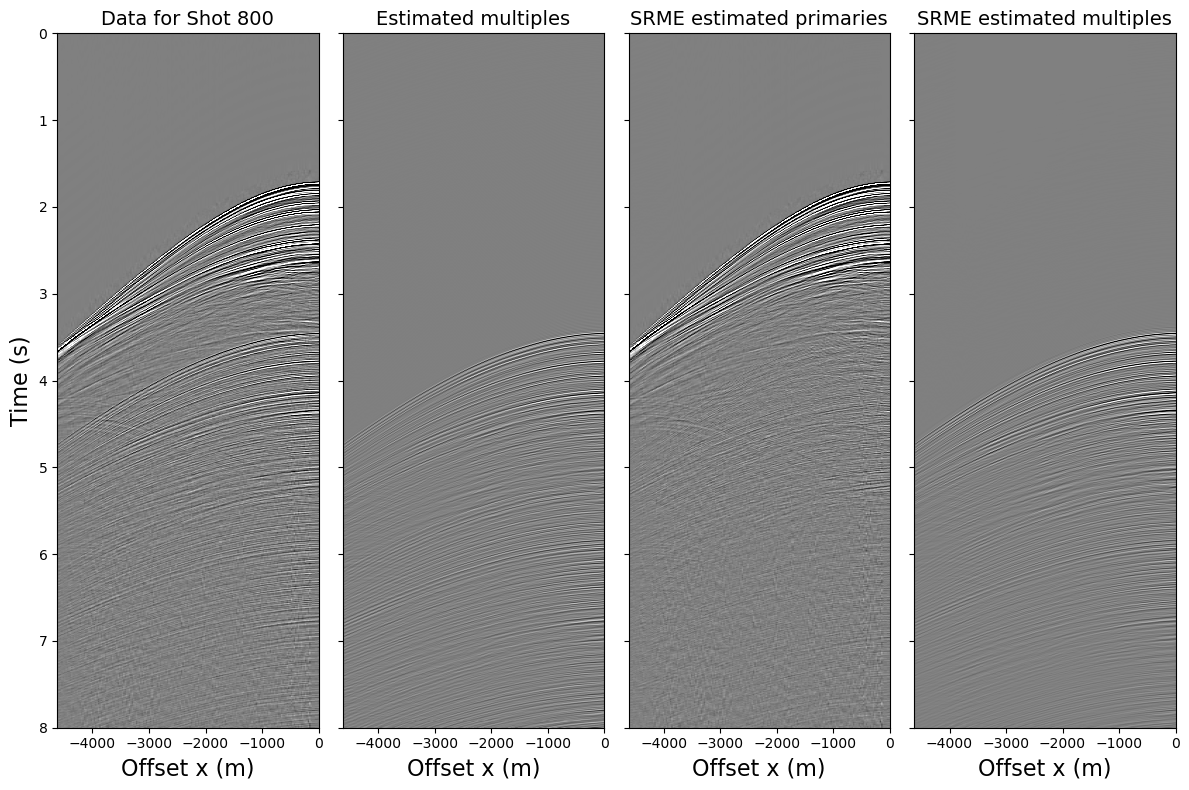

In [443]:
# Plotting parameters
vmax = 0.05 * np.amax(data)
vmin = -vmax
t0 = 0.0
t1 = t0 + (ns - 1) * dt
xmin = -4625
xmax = 0

fig, axs = plt.subplots(1, 4, figsize=(12,8),sharey=True)
axs[0].imshow(data.T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title('Data for Shot 800',fontsize=14)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(multiples.T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title('Estimated multiples',fontsize=14)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(srme.T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title('SRME estimated primaries',fontsize=14)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow((data - srme).T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[3].set_title('SRME estimated multiples',fontsize=14)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

We now apply the ADMM algorithm to the Voring dataset. For field data adaptive subtraction is done in patches, where every patch corresponds to one filter. We start by looking at the result for 1 patch first and then move on to the entire shot gather.

In [444]:
# reshape data to then patch
nr, nt = 180, 1950

data = data[:nr, :nt]
multiples = multiples[:nr, :nt]
srme = srme[:nr, :nt]

# set the filter size
nfilt =  11

# Create patching operator
dimsd = (nr, nt)  #shape of 2-dimensional data
nwin = (30, 150)  #number of samples of window
nover = (15, 75)  #number of samples of overlapping part of window
nop = nwin        #size of model in the transformed domain
nwins = (nr // (nwin[0]//2) - 1, nt // (nwin[1]//2) - 1)
dims = (nwins[0]*nop[0],   #shape of 2-dimensional model
        nwins[1]*nop[1])
I = pylops.Identity(nwin[0]*nwin[1])

# Get the patching operators
PatchOpH = pylops.signalprocessing.Patch2D(I, dims, dimsd, nwin, nover, nop, tapertype='none', design=False)
PatchOp  = pylops.signalprocessing.Patch2D(I, dims, dimsd, nwin, nover, nop, tapertype='hanning', design=False)

# Patch the data
data_patched = PatchOpH.H * shot_800.ravel()
multiples_patched = PatchOpH.H * multiples_800.ravel()

Let's check whether the patching operators are correct

In [445]:
data_back = PatchOp * data_patched
data_back = data_back.reshape(shot_800.shape)
np.linalg.norm(shot_800 - data_back)

5.512530779553429e-13

Below we select one patch indicated by the red square

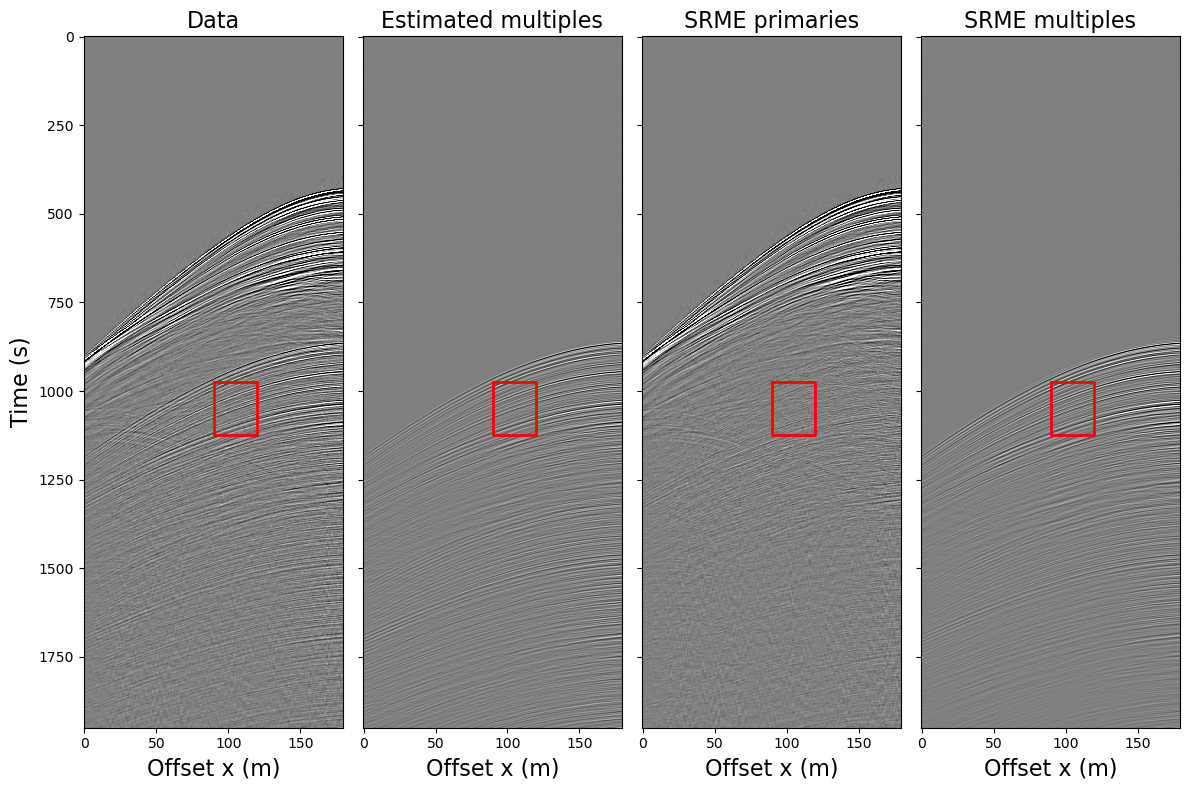

In [446]:
xs = [90, 90, 120, 120, 90]
ys = [975, 1125, 1125, 975, 975]

fig, axs = plt.subplots(1, 4, figsize=(12,8),sharey=True)
axs[0].imshow(data.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[0].set_title('Data',fontsize=16)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[0].plot(xs, ys, color='red', linewidth=2)
axs[1].imshow(multiples.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[1].set_title('Estimated multiples',fontsize=16)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[1].plot(xs, ys, color='red', linewidth=2)
axs[2].imshow(srme.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[2].set_title('SRME primaries',fontsize=16)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[2].plot(xs, ys, color='red', linewidth=2)
axs[3].imshow(data.T - srme.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[3].set_title('SRME multiples',fontsize=16)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
axs[3].plot(xs, ys, color='red', linewidth=2)
plt.tight_layout()

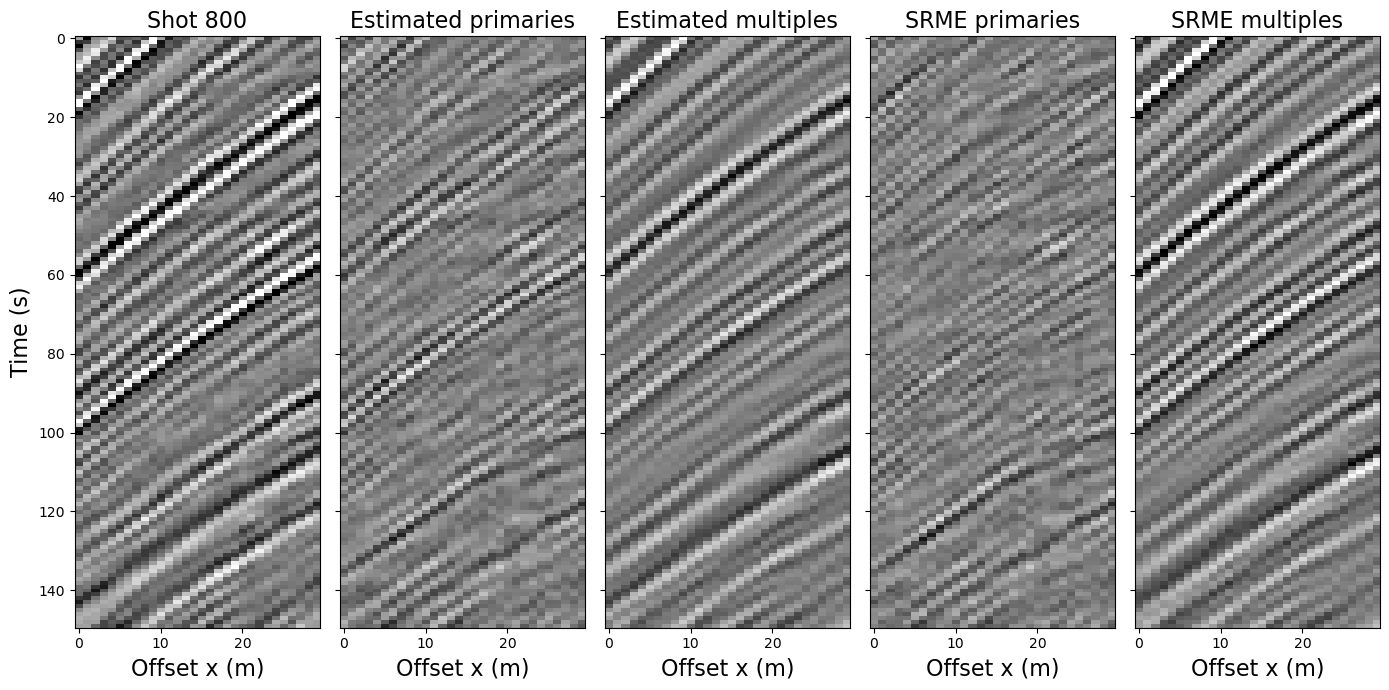

In [447]:
vmax = 0.05*np.amax(data)
vmin = -vmax

patch_data = data.T[975:1125, 90:120]
patch_multiples = multiples.T[975:1125, 90:120]
patch_srme = srme.T[975:1125, 90:120]

fig, axs = plt.subplots(1, 5, figsize=(14,7),sharey=True)
axs[0].imshow(patch_data, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[0].set_title('Shot 800',fontsize=16)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(patch_data - patch_multiples, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[1].set_title('Estimated primaries',fontsize=16)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(patch_multiples, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[2].set_title('Estimated multiples',fontsize=16)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow(patch_srme, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[3].set_title('SRME primaries',fontsize=16)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
axs[4].imshow(patch_data - patch_srme, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[4].set_title('SRME multiples',fontsize=16)
axs[4].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

We first apply adaptive subtraction using the $L_2$-norm.

In [448]:
CopStack = []
for i in range(nwin[0]):
    C = pylops.utils.signalprocessing.convmtx(patch_multiples[:, i], nfilt)
    Cop = pylops.basicoperators.MatrixMult(C[nfilt//2:-(nfilt//2)])
    CopStack.append(Cop)
    
dataStack = patch_data.T.ravel()
CopStack  = pylops.VStack(CopStack)

In [449]:
filt_est = lsqr(CopStack, dataStack, x0 = np.zeros(nfilt), damp=0, niter=int(4e1))[0]
print(np.linalg.norm(CopStack.H * (CopStack * filt_est) - CopStack.H * dataStack))
multiple_est = (CopStack * filt_est)
primary_est = dataStack.T - multiple_est
multiple_est = np.reshape(multiple_est, (nwin[0], nwin[1]))
primary_est = np.reshape(primary_est, (nwin[0], nwin[1]))

0.002834686481809903


Let's compare the results for $L_2$ adaptive subtraction to the initial estimate of SRME

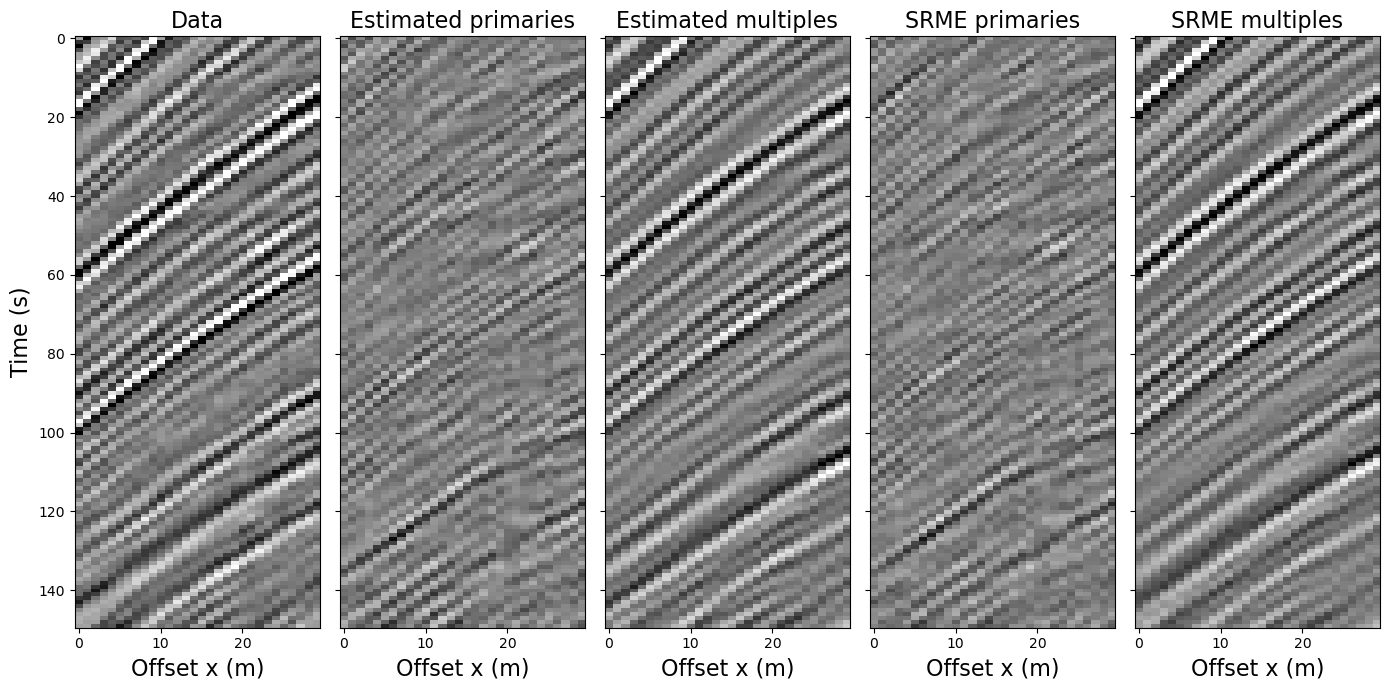

In [450]:
fig, axs = plt.subplots(1, 5, figsize=(14,7),sharey=True)
axs[0].imshow(patch_data, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[0].set_title('Data',fontsize=16)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(primary_est.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[1].set_title('Estimated primaries',fontsize=16)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(multiple_est.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[2].set_title('Estimated multiples',fontsize=16)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow(patch_srme, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[3].set_title('SRME primaries',fontsize=16)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
axs[4].imshow(patch_data - patch_srme, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[4].set_title('SRME multiples',fontsize=16)
axs[4].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

Now let's look at the estimated filter.

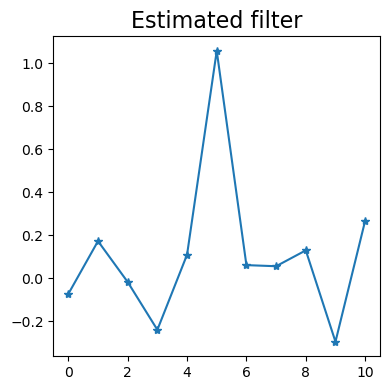

In [451]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))
axs.plot(filt_est, '*-')
axs.set_title('Estimated filter', fontsize=16)
plt.tight_layout();

Now we try to enforce a spiky filter. This can be done by imposing an $L_1$-penalty on the solution. We still use an $L_2$-norm for the data and the resulting optimization problem is solved using FISTA.

In [452]:
filt_fista = FISTA(CopStack, dataStack, niter=100, eps=3e4)[0]

# make the multiples and primaries
multiple_fista = CopStack * filt_fista
primary_fista = dataStack - multiple_fista
multiple_fista = np.reshape(multiple_fista, (nwin[0], nwin[1]))
primary_fista = np.reshape(primary_fista, (nwin[0], nwin[1]))

Let's compare the filter to the one obtained with $L_2$ regularization.

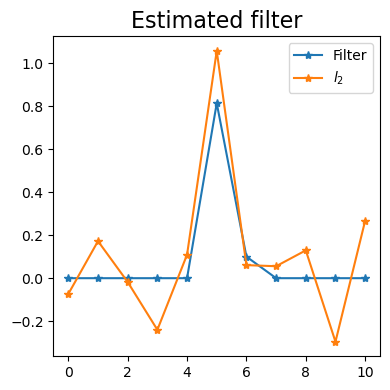

In [453]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))
axs.plot(filt_fista, '*-', label='Filter')
axs.plot(filt_est, '*-', label='$l_2$')
axs.set_title('Estimated filter', fontsize=16)
plt.tight_layout();
plt.legend();

Now we apply an $L_1$ norm on the data as well and use the modified ADMM algorithm to solve the resulting optimization problem.

In [454]:
filt_l1 = ADMM(CopStack, dataStack, rho=1e0, nouter=500, ninner=5, eps=3e7, decay=None)

# reconstruct the primaries and multiples
multiple_l1 = CopStack * filt_l1
primary_l1 = dataStack - multiple_l1
multiple_l1 = np.reshape(multiple_l1, (nwin[0], nwin[1]))
primary_l1 = np.reshape(primary_l1, (nwin[0], nwin[1]))

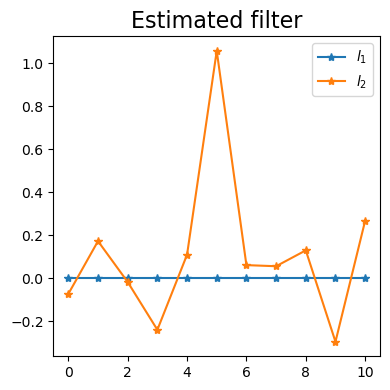

In [455]:
fig, axs = plt.subplots(1, 1, figsize=(4, 4))
axs.plot(filt_l1, '*-', label='$l_1$')
axs.plot(filt_est, '*-', label='$l_2$')
axs.set_title('Estimated filter', fontsize=16)
plt.tight_layout();
plt.legend();

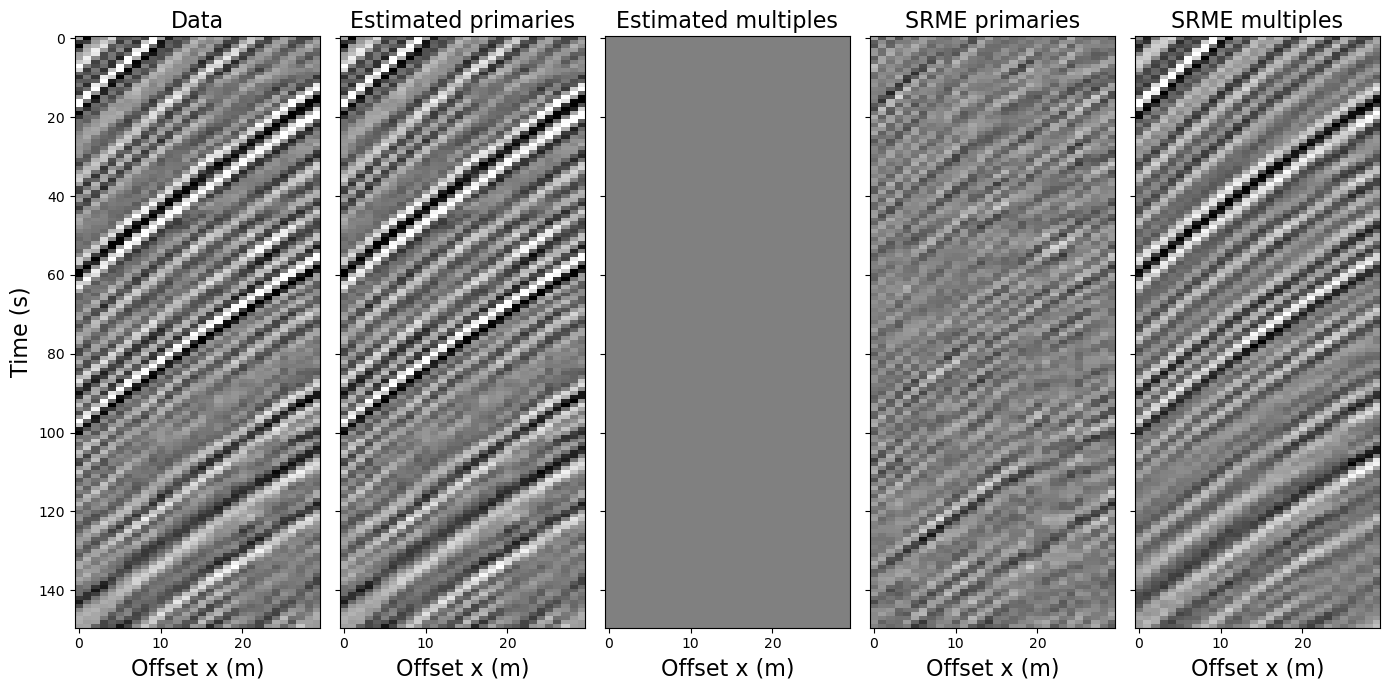

In [457]:
vmax = 0.05*np.amax(data)
vmin = -vmax
fig, axs = plt.subplots(1, 5, figsize=(14,7),sharey=True)
axs[0].imshow(patch_data, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[0].set_title('Data',fontsize=16)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(primary_l1.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[1].set_title('Estimated primaries',fontsize=16)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(multiple_l1.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[2].set_title('Estimated multiples',fontsize=16)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow(patch_srme, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[3].set_title('SRME primaries',fontsize=16)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
axs[4].imshow(patch_data - patch_srme, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[4].set_title('SRME multiples',fontsize=16)
axs[4].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

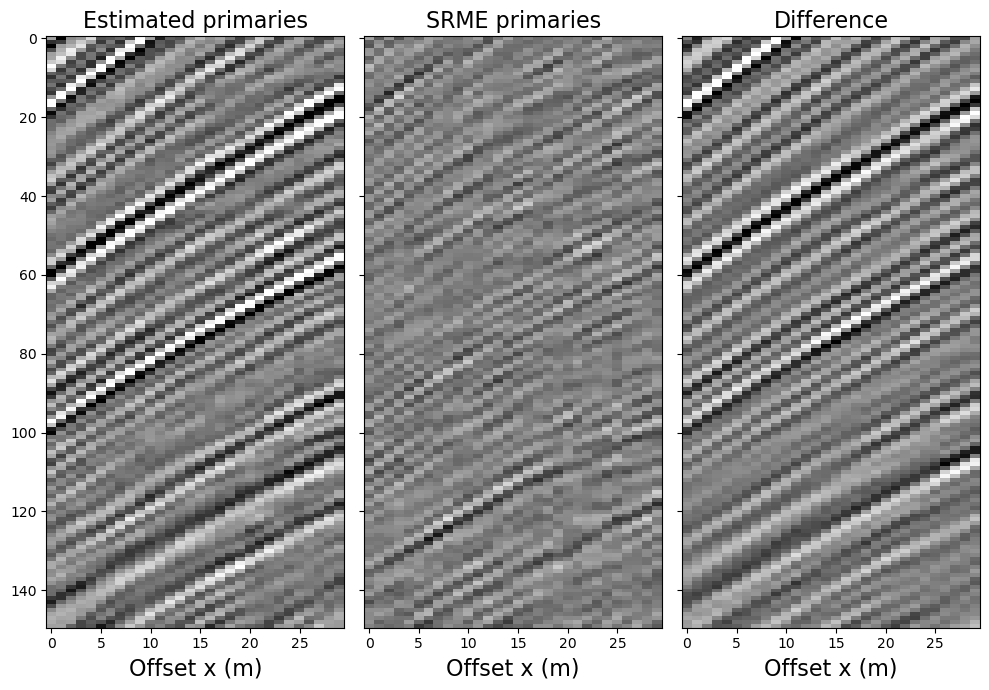

In [458]:
fig, axs = plt.subplots(1, 3, figsize=(10,7),sharey=True)
axs[0].imshow(primary_l1.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[0].set_title('Estimated primaries',fontsize=16)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[1].imshow(patch_srme, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[1].set_title('SRME primaries',fontsize=16)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(primary_l1.T - patch_srme, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[2].set_title('Difference',fontsize=16)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

Now let's look at the results when we use the IRLS algorithm instead

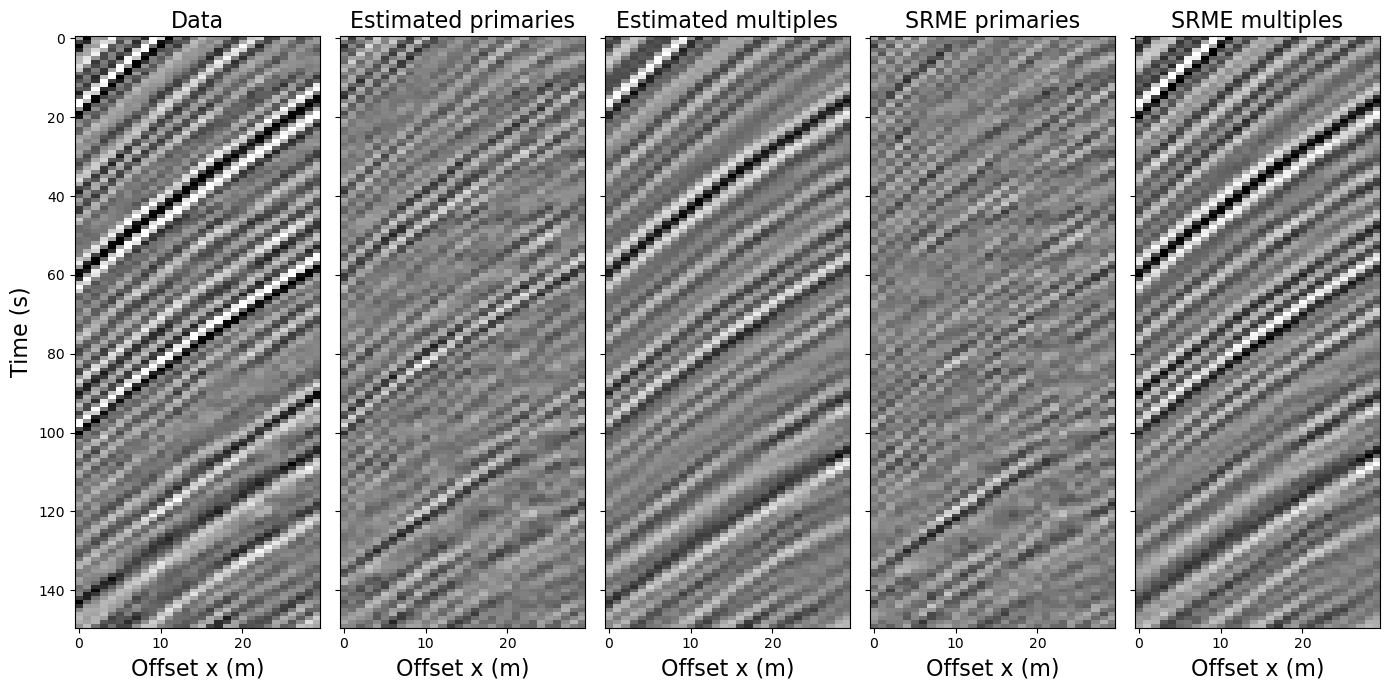

In [464]:
fig, axs = plt.subplots(1, 5, figsize=(14,7),sharey=True)
axs[0].imshow(patch_data, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[0].set_title('Data',fontsize=16)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(patch_data - patch_multiples, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[1].set_title('Estimated primaries',fontsize=16)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(patch_multiples, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[2].set_title('Estimated multiples',fontsize=16)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow(patch_srme, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[3].set_title('SRME primaries',fontsize=16)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
axs[4].imshow(patch_data - patch_srme, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[4].set_title('SRME multiples',fontsize=16)
axs[4].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

In [465]:
filt_irls = IRLS(CopStack, dataStack, nouter=4000, ninner=5, epsR=1e-2, x0=None)

# reconstruct the primaries and multiples
multiple_irls = CopStack * filt_irls
primary_irls = dataStack - multiple_irls
multiple_irls = np.reshape(multiple_irls, (nwin[0], nwin[1]))
primary_irls = np.reshape(primary_irls, (nwin[0], nwin[1]))

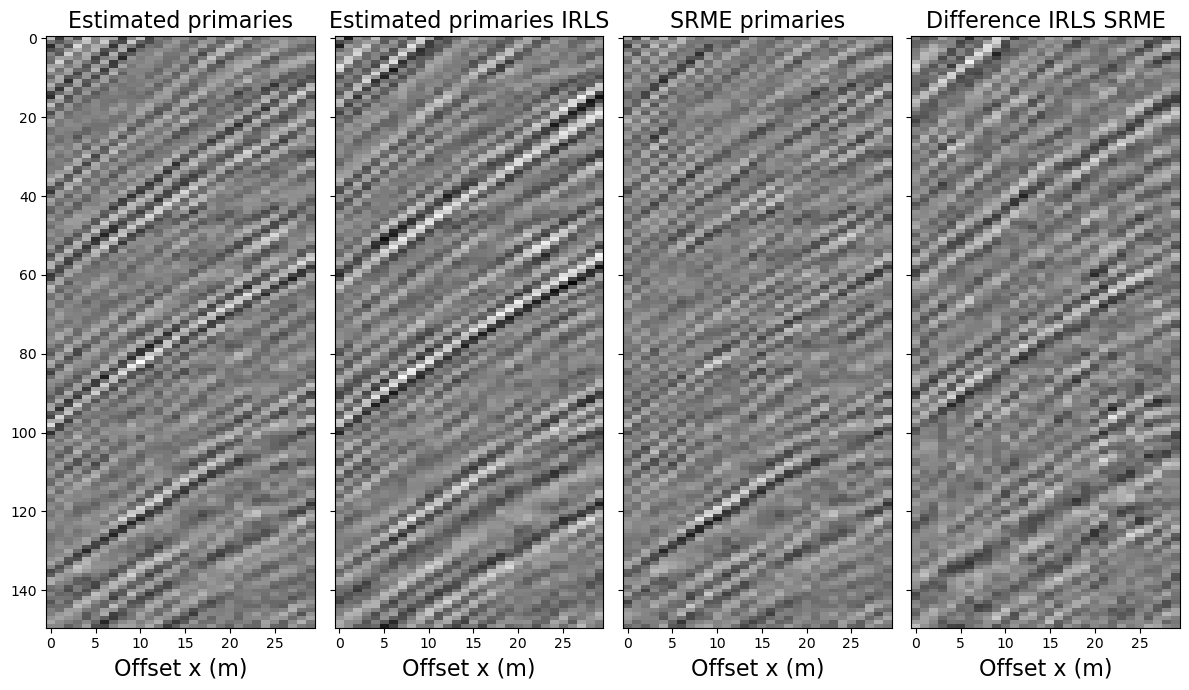

In [466]:
fig, axs = plt.subplots(1, 4, figsize=(12,7),sharey=True)
axs[0].imshow(patch_data - patch_multiples, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[0].set_title('Estimated primaries',fontsize=16)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[1].imshow(primary_irls.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[1].set_title('Estimated primaries IRLS',fontsize=16)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(patch_srme, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[2].set_title('SRME primaries',fontsize=16)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow(primary_irls.T - patch_srme, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[3].set_title('Difference IRLS SRME',fontsize=16)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()

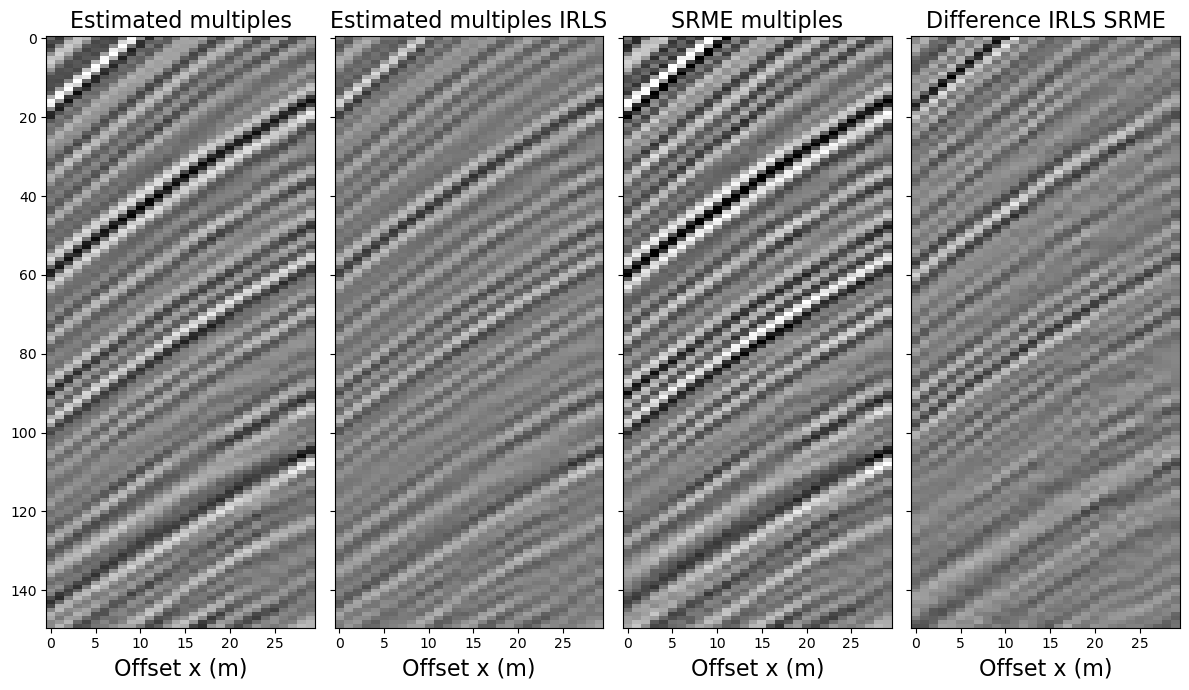

In [467]:
fig, axs = plt.subplots(1, 4, figsize=(12,7),sharey=True)
axs[0].imshow(patch_multiples, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[0].set_title('Estimated multiples',fontsize=16)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[1].imshow(multiple_irls.T, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[1].set_title('Estimated multiples IRLS',fontsize=16)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(patch_data - patch_srme, aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[2].set_title('SRME multiples',fontsize=16)
axs[2].set_xlabel('Offset x (m)',fontsize=16)
axs[3].imshow(multiple_irls.T - (patch_data - patch_srme), aspect='auto', vmin=vmin, vmax=vmax, cmap='gray')
axs[3].set_title('Difference IRLS SRME',fontsize=16)
axs[3].set_xlabel('Offset x (m)',fontsize=16)
plt.tight_layout()